In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score

from sklearn.metrics import precision_recall_fscore_support

import os
import pickle

import json

In [2]:
from json import JSONEncoder
import json
import numpy

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [3]:
def get_feature_list(model):
    
    '''This function looks for the dictionary associated with a model 
    to get the features we used during the fit automatically as a list
    '''
       
    models_path = r"C:\Users\alber\Desktop\Make Believe Diciembre\V2\Training Normalized Together\MODELS"
    dict_path = r"C:\Users\alber\Desktop\Make Believe Diciembre\V2\Training Normalized Together\DICTS"

    list_models = os.listdir(models_path)
    list_dicts = os.listdir(dict_path)
    
    # print(len(list_models), list_models)
    # print(len(list_dicts),list_dicts)
    
       
    for i in range(len(list_dicts)):

        model_name = str(model).split(".")[0]
        name_dict = str(list_dicts[i]).split(".")[0]
        
        if model_name == name_dict:
            
            dict_path = str(dict_path)+ r"\{}".format(str(list_dicts[i]))
            
            with open(dict_path) as f:
                data = json.load(f)
            
            model_name = data["name"]
            features = data["features"]
            model_type = data["model"]
        # print(features)
        
        model_path = str(models_path) + r"\{}".format(model)
        
    return features, model_name, model_type, model_path



def data_preprocess(data):
  '''We input the data with the linguistic features
  And it returns the data with the polarity columns in 0 for fake and 1 for true
  as well as the outcomes
  '''

  if data["Polarity"][0] != 0 or 1:
    data["Polarity"] = data["Polarity"].replace("Fake", 0)
    data["Polarity"] = data["Polarity"].replace("TRUE", 1)

  outcomes = ["Fake","Real"]
  
  return data, outcomes

def data_cleaning(data, features):

  '''We input the data with the features and a list of the features we want to pass to the models.
  it returns the data split in test/train
  '''

  feature_cols = features
  data = data[feature_cols + ["Polarity"]].dropna()

  X = data[feature_cols]
  y_test = data["Polarity"] #outcomes 0 or 1


  # print("Info: {} features were passed at the fit step\n:".format(X.shape[1]))
  # for feature in feature_cols:
  #   print(feature)

  return X, y_test, features

def class_report(y_test, y_pred):

  outcomes = ["Fake","Real"]

  scores = classification_report(y_test, y_pred, target_names=outcomes)

  print(scores)

  return scores


def conf_matrix(model_name, features, y_pred, y_test, cmap="magma"):

  '''This function takes the predicted and test labels, generates the confusion matrix
  and displays it
  '''

  n_features = len(features)

  confussion_matrix = confusion_matrix(y_pred, y_test)

  outcomes = ["Fake","Real"]
  ticks = np.arange(len(outcomes))

  fig, ax = plt.subplots()
  plt.xticks(ticks, outcomes)
  plt.yticks(ticks, outcomes)
  sns.heatmap(pd.DataFrame(confussion_matrix), annot=True, cmap=cmap, fmt="g", xticklabels=outcomes, yticklabels=outcomes)
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title("{} Confusion Matrix: ".format(model_name), y = 1.1)



  plt.ylabel("Actual label")
  plt.xlabel("Predicted label")

  return confussion_matrix

def compare_models_train_test_split(model, model_type, model_name, X, y_test, features):

  '''this fx trains the data on the four types of models,
  generates a report with the overall accuracy of the model, the cross validation evaluation
  and prints the confussion matrix of each model on the particular test_train split.

  It returns a dictionary with the name of the model, the features that were passed during the fit,
  the model used, the accuracy score, the classification report, the cross-validation evaluation and the confusion matrix
  '''
    
    
    
  model_dict = {}

  model_dict["name"] = model_name

  model_dict["features"] = features

  model_dict["model"] = model_type

  print("\n",model_name, "\n", "\n")

  y_pred = model.predict(X)

  accuracy = accuracy_score(y_test, y_pred)

  model_dict["accuracy"] = accuracy

  print("OVERALL ACCURACY", model_dict["name"], ":", round(accuracy*100, 2),"%""\n")

  scores = class_report(y_test, y_pred)

  P_R_F1_true = precision_recall_fscore_support(y_test, y_pred, labels=[1])
  precision_true, recall_true , f1_score_true  = P_R_F1_true[0], P_R_F1_true[1] ,  P_R_F1_true[2]

  P_R_F1_false = precision_recall_fscore_support(y_test, y_pred, labels=[0])
  precision_false, recall_false, f1_score_false = P_R_F1_false[0], P_R_F1_false[1], P_R_F1_false[2]

  model_dict["precision_true"], model_dict["recall_true"], model_dict["f1_score_true"] = precision_true, recall_true, f1_score_true
  model_dict["precision_false"], model_dict["recall_false"], model_dict["f1_score_false"] = precision_false, recall_false, f1_score_false

  confussion_matrix = conf_matrix(model_name, features, y_pred, y_test, cmap="magma")

  model_dict["confussion_matrix"] = confussion_matrix
  
  model_dict["data_test_source"] = "second dataset"
  
  model_dict["training_normalized_together"] = "yes"

  model_dict["testing_normalized_together"] = "no"

  with open(r"C:\Users\alber\Desktop\Make Believe Diciembre\V2\Testing\Testing not normalized togehter\With normalized trainng\{}_TEST.json".format(model_dict["name"]), "w") as f:
    json.dump(model_dict, f, cls=NumpyArrayEncoder)
    
    
  return model_dict





In [4]:
def magic_eva(data, model):

  '''this function takes all the previous functions and integrates them into a single function to run the data processing, training and testing in all the models.

  It returns a dictionary with the name of the model, the features that were passed during the fit,
  the model used, the accuracy score, the classification report, the crossvalidation evaluation and the confusion matrix

  '''
  
  features, model_name, model_type, model_path = get_feature_list(model)

  data, outcomes = data_preprocess(data) # data in the correct format for the y outcomes

  X, y_test, features = data_cleaning(data, features) # data split for all the models with the desired features
  
  model = pickle.load(open (model_path, "rb"))

  model_dict = compare_models_train_test_split(model, model_type, model_name, X, y_test, features) # for each model it will compute

  return model_dict

In [5]:
data = pd.read_csv(r"C:\Users\alber\Desktop\Make Believe Diciembre\Data\Model Testing\test_data")


 All_features__KNeighborsClassifier 
 

OVERALL ACCURACY All_features__KNeighborsClassifier : 52.92 %

              precision    recall  f1-score   support

        Fake       0.60      0.24      0.34      3079
        Real       0.51      0.83      0.63      2968

    accuracy                           0.53      6047
   macro avg       0.55      0.53      0.49      6047
weighted avg       0.55      0.53      0.48      6047


 All_features__LogisticRegression 
 

OVERALL ACCURACY All_features__LogisticRegression : 56.42 %

              precision    recall  f1-score   support

        Fake       0.54      0.91      0.68      3079
        Real       0.68      0.21      0.32      2968

    accuracy                           0.56      6047
   macro avg       0.61      0.56      0.50      6047
weighted avg       0.61      0.56      0.50      6047


 All_features__RandomForestClassifier 
 

OVERALL ACCURACY All_features__RandomForestClassifier : 64.05 %

              precision    recall 

C:\Users\alber\AppData\Local\Temp\ipykernel_19768\458526870.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()



 DESWLltd__WORD_PROPERTY_WRDHYPn__SVC 
 

OVERALL ACCURACY DESWLltd__WORD_PROPERTY_WRDHYPn__SVC : 70.62 %

              precision    recall  f1-score   support

        Fake       0.63      0.99      0.77      3134
        Real       0.99      0.42      0.59      3170

    accuracy                           0.71      6304
   macro avg       0.81      0.71      0.68      6304
weighted avg       0.81      0.71      0.68      6304



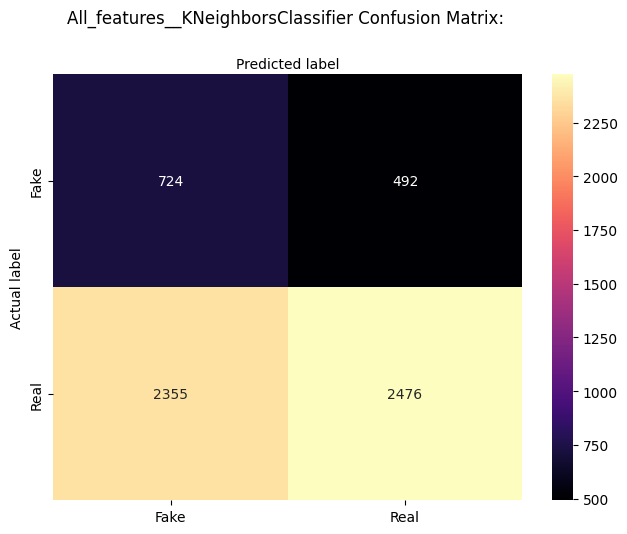

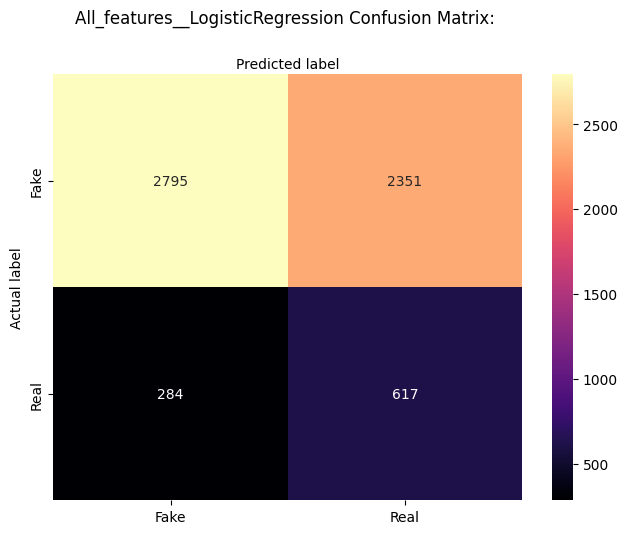

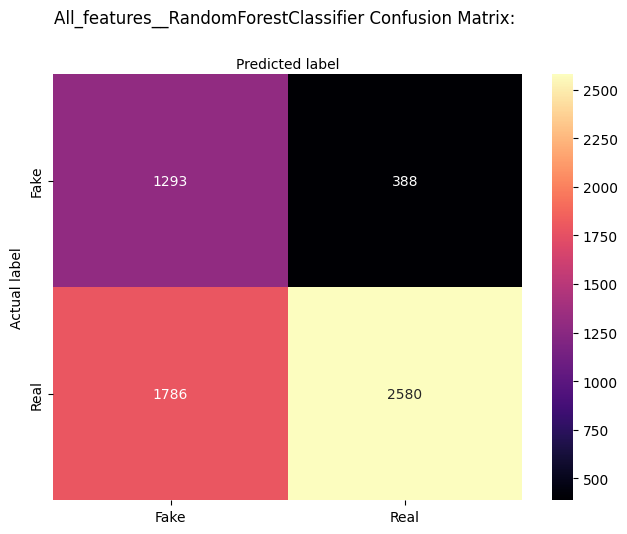

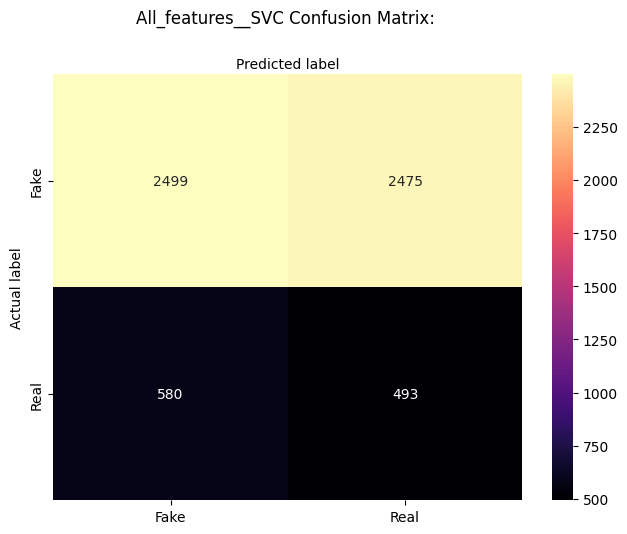

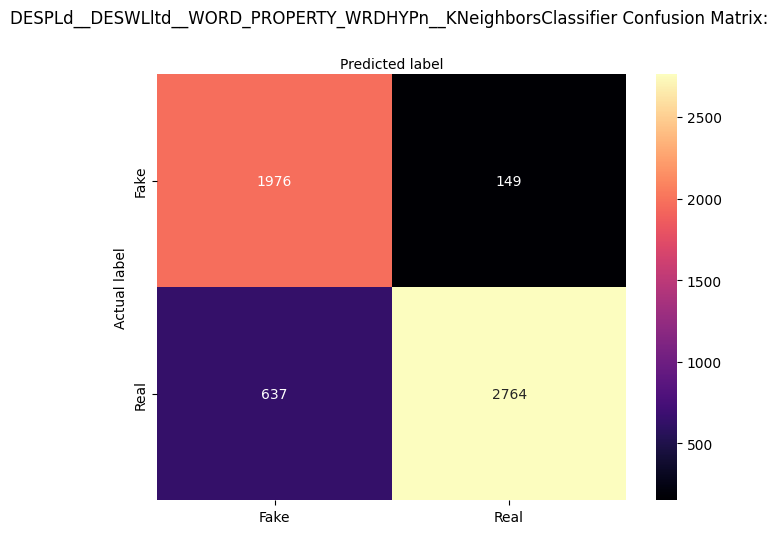

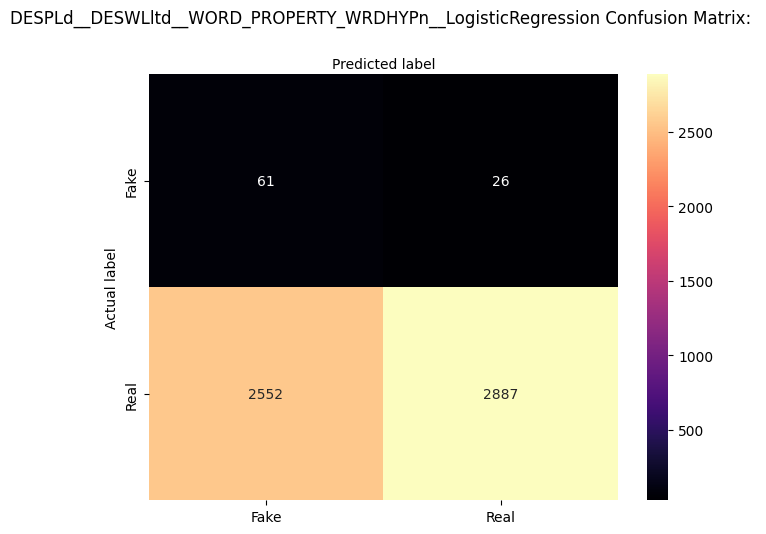

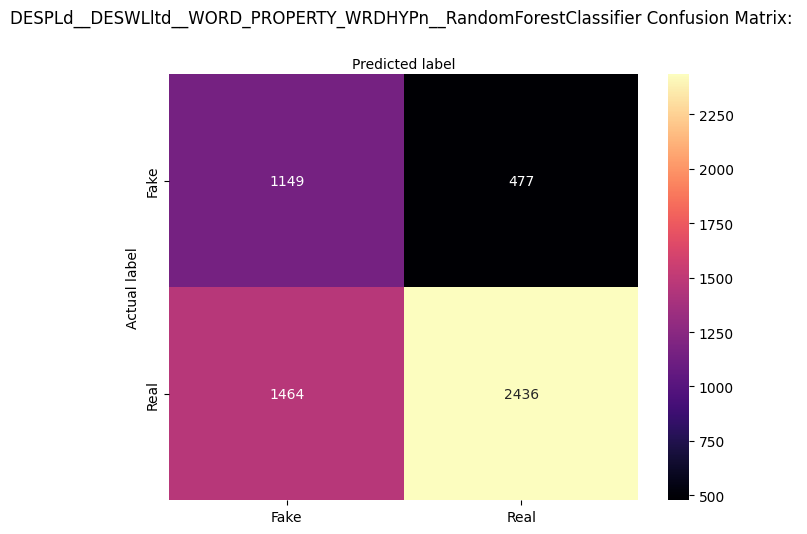

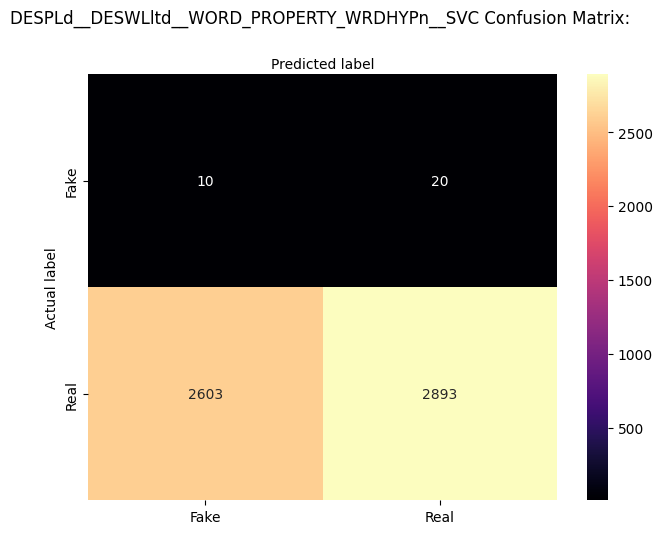

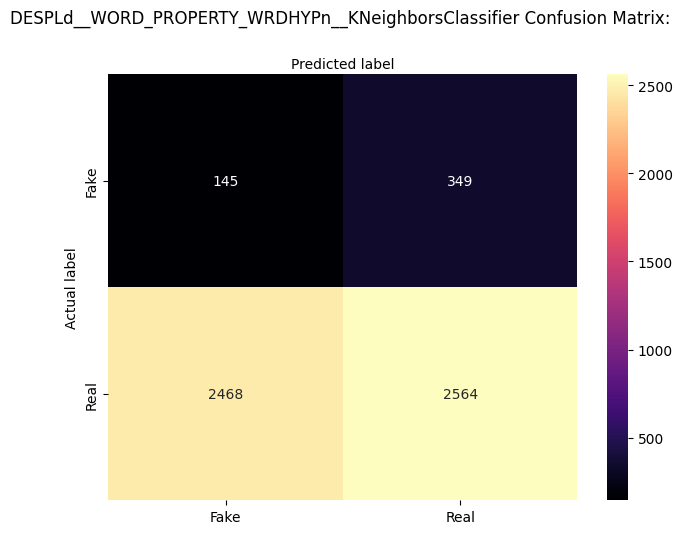

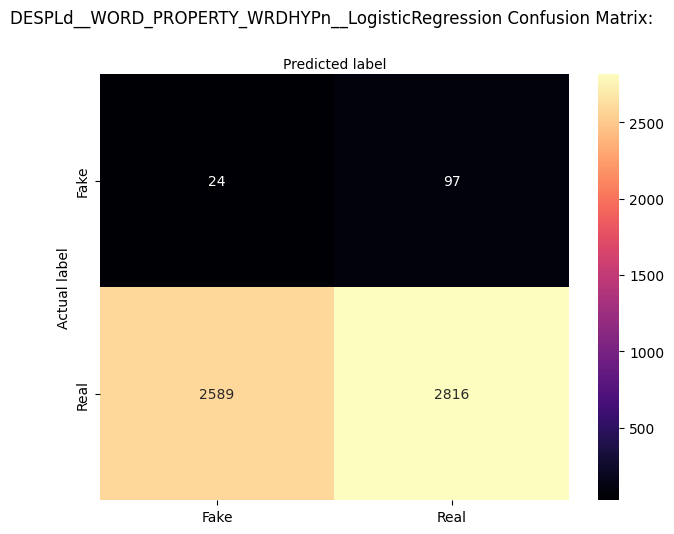

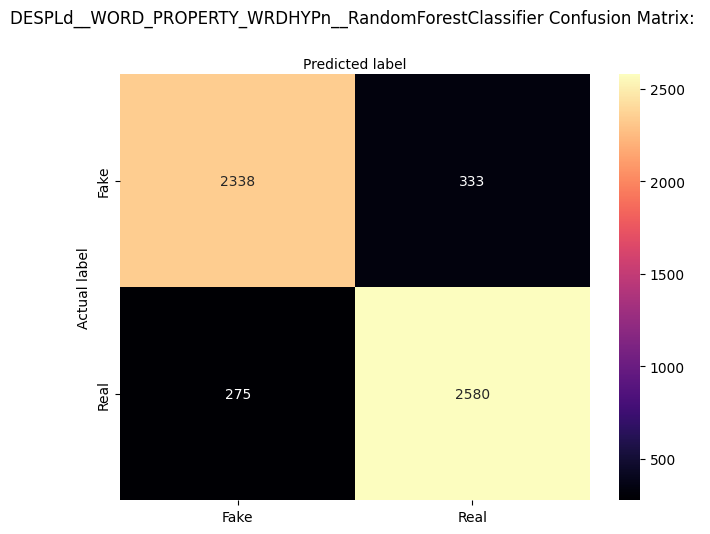

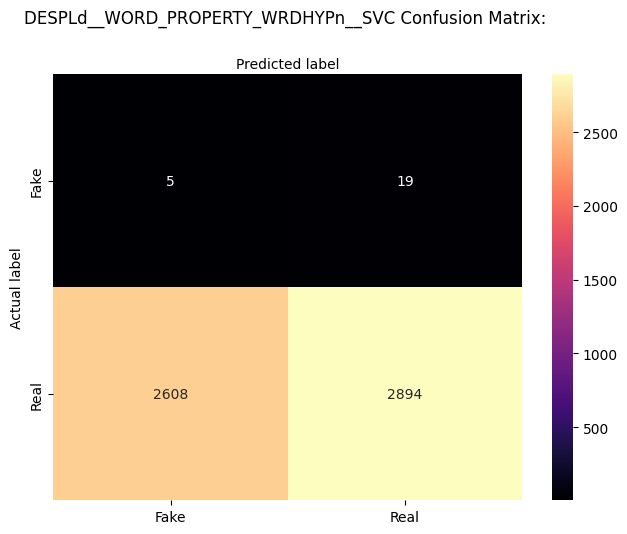

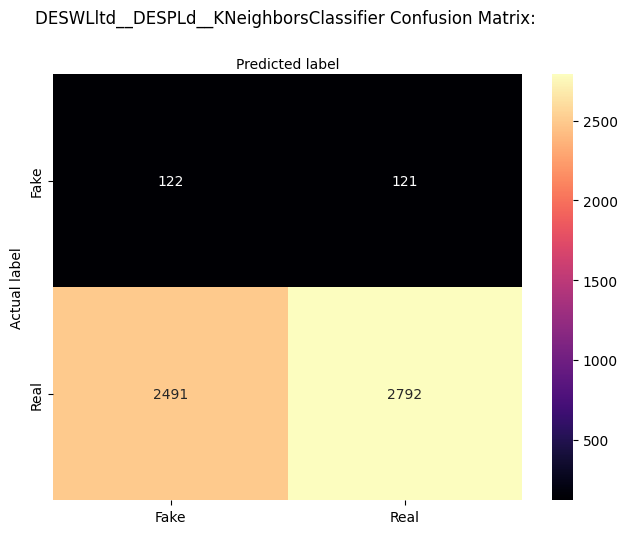

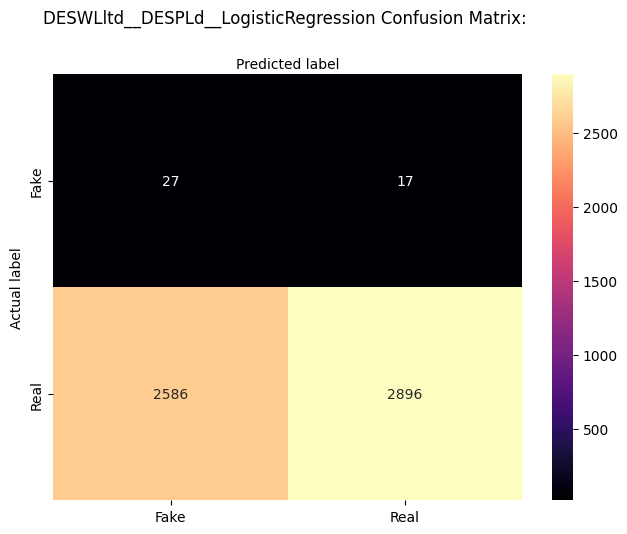

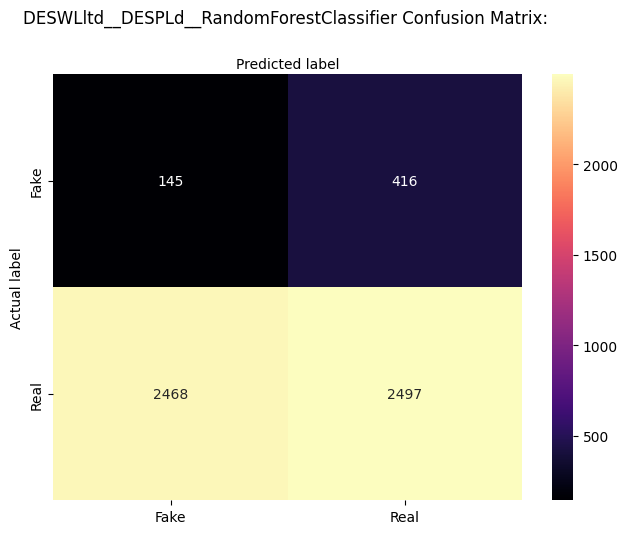

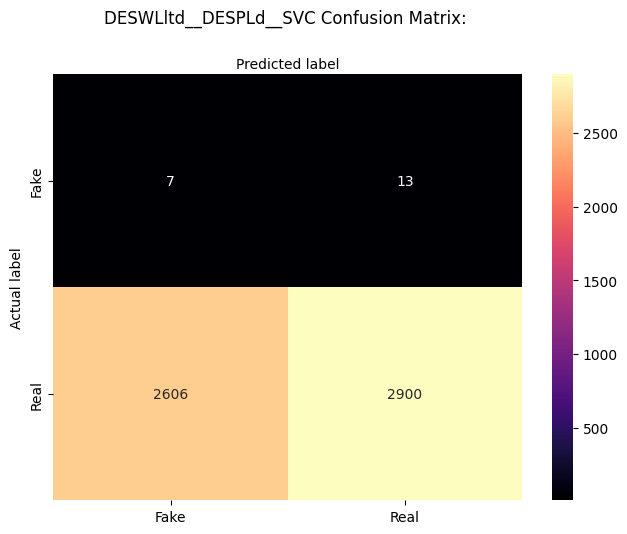

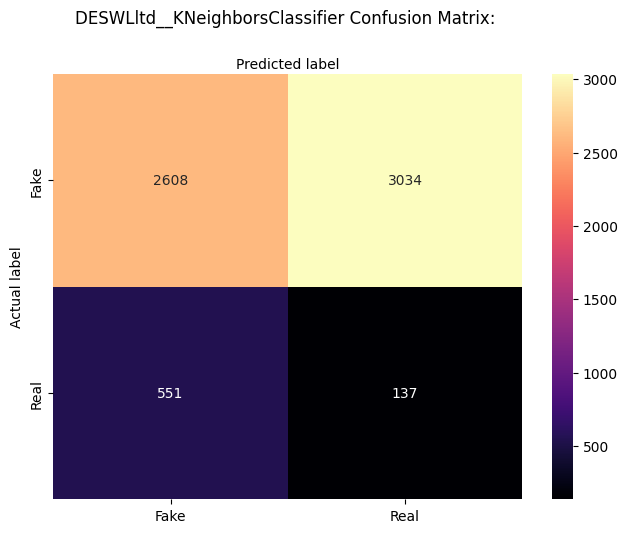

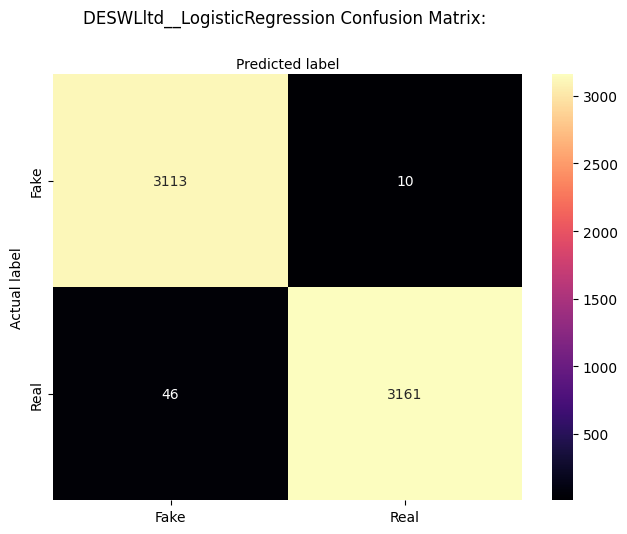

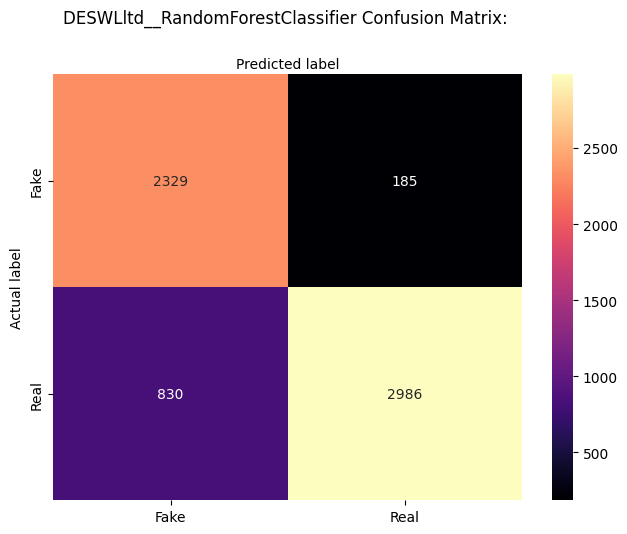

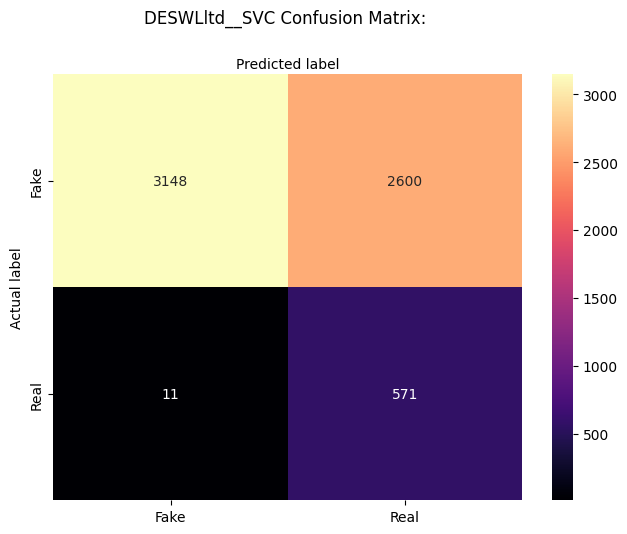

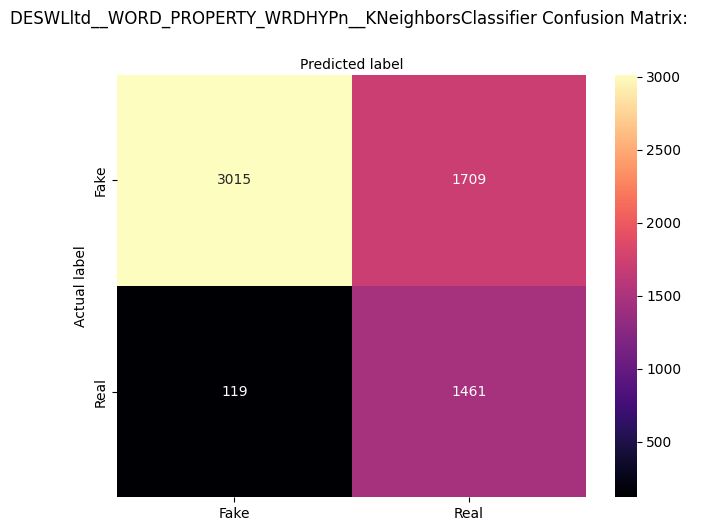

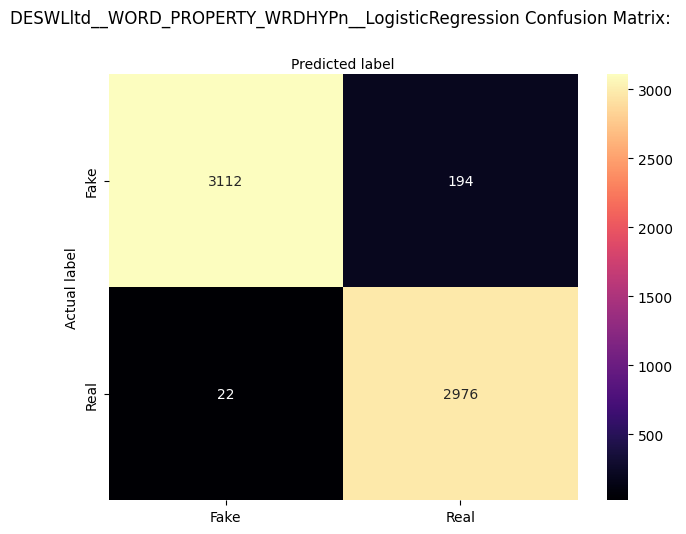

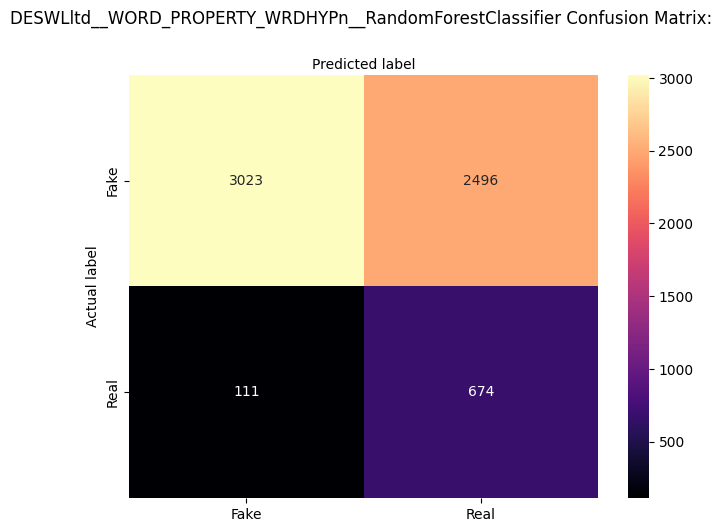

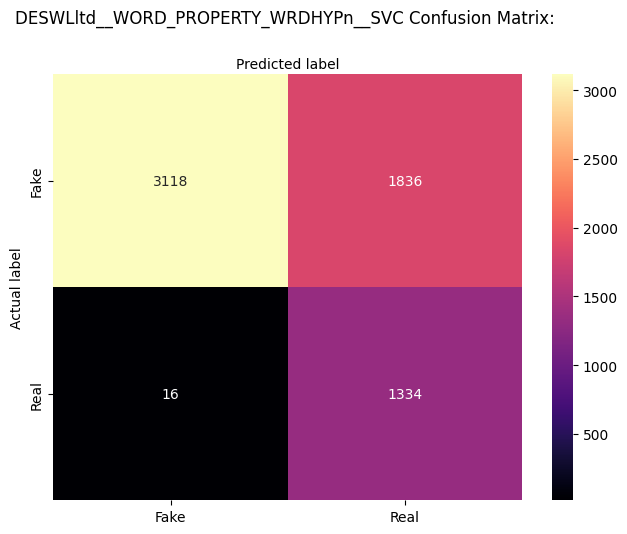

In [6]:
models_path = r"C:\Users\alber\Desktop\Make Believe Diciembre\V2\Training Normalized Together\MODELS"
dict_path = r"C:\Users\alber\Desktop\Make Believe Diciembre\V2\Training Normalized Together\DICTS"

list_models = os.listdir(models_path)
list_dicts = os.listdir(dict_path)

list_dicts_performance = []

for model in list_models:
    dict_model = magic_eva(data, model)
    
    list_dicts_performance.append(dict_model)
    # print(dict_model)

In [7]:
print(len(list_dicts_performance))
print(list_dicts_performance)

24
[{'name': 'All_features__KNeighborsClassifier', 'features': ['DESPC', 'DESSC', 'DESWC', 'DESPL', 'DESPLw', 'DESSL', 'DESSLd', 'DESWLsy', 'DESWLsyd', 'DESWLlt', 'DESWLltd', 'LDTTRc', 'LDTTRa', 'LDMTLD', 'LDHDD', 'SYNLE', 'SYNNP', 'SYNMEDpos', 'SYNMEDwrd', 'SYNMEDlem', 'SYNSTRUTa', 'RDFRE', 'READFKGL', 'TOKEN_ATTRIBUTE_RATIO_ALHPA', 'TOKEN_ATTRIBUTE_RATIO_DIGIT', 'TOKEN_ATTRIBUTE_RATIO_PUNCT', 'TOKEN_ATTRIBUTE_RATIO_URL', 'WORD_SET_INCIDENCE_WRDPRP1s', 'WORD_SET_INCIDENCE_WRDPRP1p', 'WORD_SET_INCIDENCE_WRDPRP2', 'WORD_SET_INCIDENCE_WRDPRP3s', 'WORD_SET_INCIDENCE_WRDPRP3p', 'WORD_SET_INCIDENCE_CNCCaus', 'WORD_SET_INCIDENCE_CNCLogic', 'WORD_SET_INCIDENCE_CNCTemp', 'WORD_SET_INCIDENCE_CNCAdd', 'WORD_SET_INCIDENCE_CNCPos', 'WORD_SET_INCIDENCE_CNCNeg', 'WORD_PROPERTY_WRDNOUN', 'WORD_PROPERTY_WRDVERB', 'WORD_PROPERTY_WRDADJ', 'WORD_PROPERTY_WRDADV', 'WORD_PROPERTY_WRDFRQc', 'WORD_PROPERTY_WRDFRQa', 'WORD_PROPERTY_WRDFRQmc', 'WORD_PROPERTY_WRDFAMc', 'WORD_PROPERTY_WRDCNCc', 'WORD_PROPERTY_WR

do a mirror pair of models trained with this data and tested in the second dataset/fine tune

'''

small crossvalidation to make sure model is stableand std bt the scores , lucky distr.

data augmentation - + at the end with the generation model, feed the model with new elements

method to input some text and see the prediction irt,
automatically add fake news text to the data


this is quant but we need qualitative

SMOTE libary for DAug

name of the file and template of the acl file - subsections things

qualitative vs quantitative studies

'''